In [1]:
import tensorflow as tf
from tensorflow import keras
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from keras import backend as K
from keras import backend
from keras import ops

2024-04-18 09:44:22.366350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 09:44:22.366430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 09:44:22.392276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 09:44:22.478461: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 09:44:23.776189: W tensorflow/compiler/tf2

In [2]:
tf.test.is_built_with_cuda()

True

In [25]:
# utils.py

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# def plot_side_by_side(image1, image2, title1='', title2=''):
#     fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#     axes[0].imshow(image1)
#     axes[0].set_title(title1)
#     axes[0].axis('off')
#     axes[1].imshow(image2)
#     axes[1].set_title(title2)
#     axes[1].axis('off')
#     plt.show()

def plot_side_by_side(image1, image2, title1='', title2=''):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    axes[0].imshow(image1)
    axes[0].set_title(title1)
    axes[0].axis('off')


    axes[1].imshow(image2)
    axes[1].set_title(title2)
    axes[1].axis('off')

    plt.show()

# Function to read and decode images
def parse_image(image_path, mask_path):

    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels = 3)  # Adjust channels as needed
    image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, dtype = tf.float32)
    image = image / 255.0

    # Read and decode the mask image
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Assuming mask is grayscale
    mask = tf.squeeze(mask, axis = -1)
    mask = tf.cast(mask > 128, dtype = tf.float32)


    return image, mask

In [23]:
# Train dataset
train_img_files = glob("../data/contrastprocessed/train/images/*")
train_msk_files = glob("../data/processed/train/masks/*")

# Test dataset
test_img_files = glob("../data/contrastprocessed/test/images/*")
test_msk_files = glob("../data/processed/test/masks/*")

# Validation dataset
val_img_files = glob("../data/contrastprocessed/val/images/*")
val_msk_files = glob("../data/processed/val/masks/*")

train_files = []
test_files = []
validation_files = []

for file in train_img_files:
    train_files.append(file.split(sep = "/")[-1])

for file in test_img_files:
    test_files.append(file.split(sep = "/")[-1])

for file in val_img_files:
    validation_files.append(file.split(sep = "/")[-1])

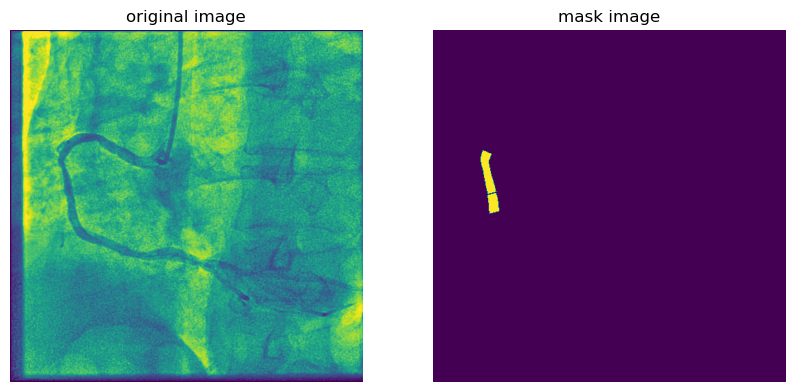

In [26]:
img, msk = parse_image(image_path = "../data/contrastprocessed/train/images/100.png",
                       mask_path = "../data/processed/train/masks/100.png")
plot_side_by_side(img, msk, title1 = "original image", title2 = "mask image")

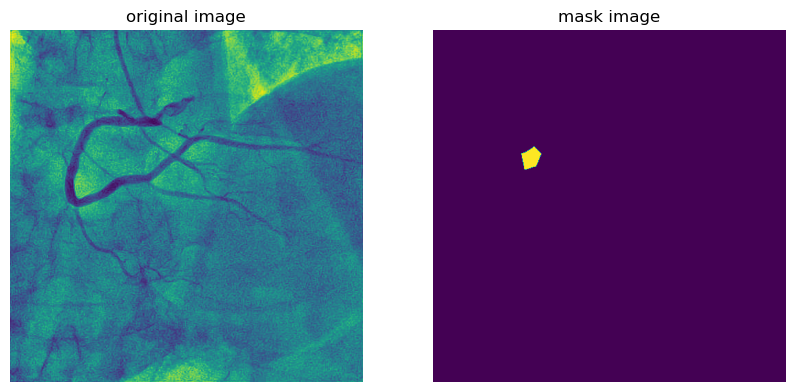

In [27]:
img, msk = parse_image(image_path = "../data/contrastprocessed/train/images/200.png",
                       mask_path = "../data/processed/train/masks/200.png")
plot_side_by_side(img, msk, title1 = "original image", title2 = "mask image")

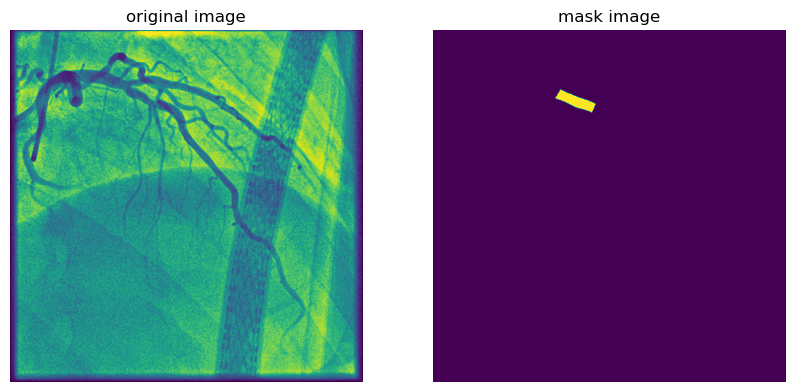

In [28]:
img, msk = parse_image(image_path = "../data/contrastprocessed/train/images/400.png",
                       mask_path = "../data/processed/train/masks/400.png")
plot_side_by_side(img, msk, title1 = "original image", title2 = "mask image")

## Dataset Creating

In [45]:
# Creating image and masks files for each dataset split

train_data_directory = "../data/contrastprocessed/train/"
test_data_directory = "../data/contrastprocessed/test/"
val_data_directory = "../data/contrastprocessed/val/"

train_image_files = [os.path.join(train_data_directory, "images", f) for f in train_files]
train_masks_files = [os.path.join(train_data_directory, "masks", f) for f in train_files]

test_image_files = [os.path.join(test_data_directory, "images", f) for f in test_files]
test_masks_files = [os.path.join(test_data_directory, "masks", f) for f in test_files]

val_image_files = [os.path.join(val_data_directory, "images", f) for f in validation_files]
val_masks_files = [os.path.join(val_data_directory, "masks", f) for f in validation_files]

In [46]:
# Creating tf data pipeline for train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_files, train_masks_files))

# Creating tf data pipeline for test dataseta
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_files, test_masks_files))

# Creating tf data pipeline for validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_files, val_masks_files))

# Preparing the data
multi_auto = tf.data.AUTOTUNE
BATCH_SIZE = 2

# Preparing the data for prefetching and batching
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1000, reshuffle_each_iteration = True)
    .map(parse_image, num_parallel_calls = multi_auto)
    .batch(BATCH_SIZE)
    .prefetch(multi_auto) 
)

# Preparing the data for prefetching and batching
test_dataset = (
    test_dataset
    .map(parse_image, num_parallel_calls = multi_auto)
    .batch(BATCH_SIZE)
    .prefetch(multi_auto) 
)

# Preparing the data for prefetching and batching
val_dataset = (
    val_dataset
    .map(parse_image, num_parallel_calls = multi_auto)
    .batch(BATCH_SIZE)
    .prefetch(multi_auto) 
)

In [47]:
img, msk = next(iter(val_dataset))

## Modelling Part

In [57]:
import keras
from keras.layers import SeparableConv2D, BatchNormalization, Add, Conv2DTranspose, Conv2D
from keras.layers import Input

def resblock(input_, filters):
    input_ = BatchNormalization()(input_)
    sepconv_1 = SeparableConv2D(filters, (3, 3), activation='relu', padding='same')(input_)
    sepconv_2 = SeparableConv2D(filters, (3, 3), activation='relu', padding='same')(sepconv_1)
    batch_1 = BatchNormalization()(sepconv_2)
    add = Add()([input_, batch_1])

    sepconv_1 = SeparableConv2D(filters, (3, 3), activation='relu', padding='same')(add)
    sepconv_2 = SeparableConv2D(filters, (3, 3), activation='relu', padding='same')(sepconv_1)
    batch_1 = BatchNormalization()(sepconv_2)

    add = Add()([input_, batch_1])
    batch = BatchNormalization()(add)
    return batch

def get_model():
    input_1 = Input(shape=(512, 512, 1))
    conv = SeparableConv2D(16, (3, 3), padding='same')(input_1)  # Reduce channels to 16

    res_1 = resblock(conv, 16)
    conv_1 = SeparableConv2D(32, (2, 2), strides=2, padding='same')(res_1)  # Reduce channels to 32

    res_2 = resblock(conv_1, 32)
    conv_2 = SeparableConv2D(64, (2, 2), strides=2, padding='same')(res_2)  # Reduce channels to 64

    res_3 = resblock(conv_2, 64)
    conv_3 = SeparableConv2D(128, (2, 2), strides=2, padding='same')(res_3)  # Reduce channels to 128

    res_4 = resblock(conv_3, 128)
    conv_4 = SeparableConv2D(256, (2, 2), strides=2, padding='same')(res_4)  # Reduce channels to 256

    res_7 = resblock(conv_4, 256)
    res_8 = resblock(res_7, 256)
    res_9 = resblock(res_8, 256)

    trconv_3 = Conv2DTranspose(128, (2, 2), strides=2, padding='same')(res_9)  # Reduce channels to 128
    res_12 = resblock(trconv_3, 128)
    add_3 = Add()([res_12, res_4])

    trconv_4 = Conv2DTranspose(64, (2, 2), strides=2, padding='same')(add_3)  # Reduce channels to 64
    res_13 = resblock(trconv_4, 64)
    add_4 = Add()([res_13, res_3])

    trconv_5 = Conv2DTranspose(32, (2, 2), strides=2, padding='same')(add_4)  # Reduce channels to 32
    res_14 = resblock(trconv_5, 32)
    add_5 = Add()([res_14, res_2])

    trconv_6 = Conv2DTranspose(16, (2, 2), strides=2, padding='same')(add_5)  # Reduce channels to 16
    res_15 = resblock(trconv_6, 16)
    add_6 = Add()([res_15, res_1])

    conv_7 = SeparableConv2D(16, (3, 3), activation='relu', padding='same')(add_6)  # Adjust channels to 16
    batch_1 = BatchNormalization()(conv_7)
    conv_8 = SeparableConv2D(16, (3, 3), activation='relu', padding='same')(batch_1)  # Adjust channels to 16
    batch_2 = BatchNormalization()(conv_8)
    out1 = Conv2D(1, (1, 1), activation='sigmoid', padding='same', name='seg')(batch_2)

    model = keras.Model(inputs=[input_1], outputs=[out1], name="model1")

    return model

# Build model
model = get_model()
model.summary()

Model: "model1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 512, 512,  │         41 │ input_layer_2[0]… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 512, 512,  │        416 │ batch_normalizat… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 512, 512,  │        416 │ separable_conv2d… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_52 (Add)        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 512, 512,  │        416 │ add_52[0][0]      │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 512, 512,  │        416 │ separable_conv2d… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_53 (Add)        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ add_53[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 256, 256,  │        608 │ batch_normalizat… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 256, 256,  │      1,344 │ batch_normalizat… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 256, 256,  │      1,344 │ separable_conv2d… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ separable_conv2d

 Total params: 1,250,698 (4.77 MB)

 Trainable params: 1,240,650 (4.73 MB)

 Non-trainable params: 10,048 (39.25 KB)

In [58]:
from keras import backend
from keras import ops

def dice_loss(y_true, y_pred):
    """Computes the Dice loss value between `y_true` and `y_pred`.

    Formula:
    ```python
    loss = 1 - (2 * sum(y_true * y_pred)) / (sum(y_true) + sum(y_pred))
    ```

    Args:
        y_true: tensor of true targets.
        y_pred: tensor of predicted targets.

    Returns:
        Dice loss value.
    """
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = ops.cast(y_true, y_pred.dtype)

    inputs = ops.reshape(y_true, [-1])
    targets = ops.reshape(y_pred, [-1])

    intersection = ops.sum(inputs * targets)
    dice = ops.divide(
        2.0 * intersection,
        ops.sum(y_true) + ops.sum(y_pred) + backend.epsilon(),
    )

    return 1 - dice


def dice_coefficient(y_true, y_pred):
    """Computes the Dice loss value between `y_true` and `y_pred`.

    Formula:
    ```python
    loss = 1 - (2 * sum(y_true * y_pred)) / (sum(y_true) + sum(y_pred))
    ```

    Args:
        y_true: tensor of true targets.
        y_pred: tensor of predicted targets.

    Returns:
        Dice loss value.
    """
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = ops.cast(y_true, y_pred.dtype)

    inputs = ops.reshape(y_true, [-1])
    targets = ops.reshape(y_pred, [-1])

    intersection = ops.sum(inputs * targets)
    dice = ops.divide(
        2.0 * intersection,
        ops.sum(y_true) + ops.sum(y_pred) + backend.epsilon(),
    )

    return dice 

In [59]:
initial_learning_rate = 0.0001
decay_steps = 167 * 100
warmup_steps = 1000
target_learning_rate = 0.1

# Create learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps, warmup_target=target_learning_rate,
    warmup_steps=warmup_steps
)

model.compile(loss=dice_loss,
              optimizer = tf.keras.optimizers.Adam(learning_rate = initial_learning_rate, gradient_accumulation_steps = 4),
              metrics = [tf.keras.metrics.BinaryIoU(target_class_ids = [0,1]), dice_coefficient])

In [60]:
model.fit(train_dataset, epochs = 200, initial_epoch = 0, validation_data = val_dataset)

Epoch 1/200


2024-04-18 10:01:59.497604: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert/Assert


498/499 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - binary_io_u_2: 0.2617 - dice_coefficient: 0.0172 - loss: 0.9828

2024-04-18 10:12:13.875581: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert/Assert


499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_io_u_2: 0.2618 - dice_coefficient: 0.0172 - loss: 0.9828

2024-04-18 10:13:25.859969: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator Assert/Assert


499/499 ━━━━━━━━━━━━━━━━━━━━ 760s 1s/step - binary_io_u_2: 0.2618 - dice_coefficient: 0.0173 - loss: 0.9827 - val_binary_io_u_2: 0.3451 - val_dice_coefficient: 0.0150 - val_loss: 0.9850
Epoch 2/200
499/499 ━━━━━━━━━━━━━━━━━━━━ 561s 1s/step - binary_io_u_2: 0.2820 - dice_coefficient: 0.0311 - loss: 0.9689 - val_binary_io_u_2: 0.3395 - val_dice_coefficient: 0.0300 - val_loss: 0.9700
Epoch 3/200
 80/499 ━━━━━━━━━━━━━━━━━━━━ 6:29 930ms/step - binary_io_u_2: 0.3998 - dice_coefficient: 0.0437 - loss: 0.9563


KeyboardInterrupt



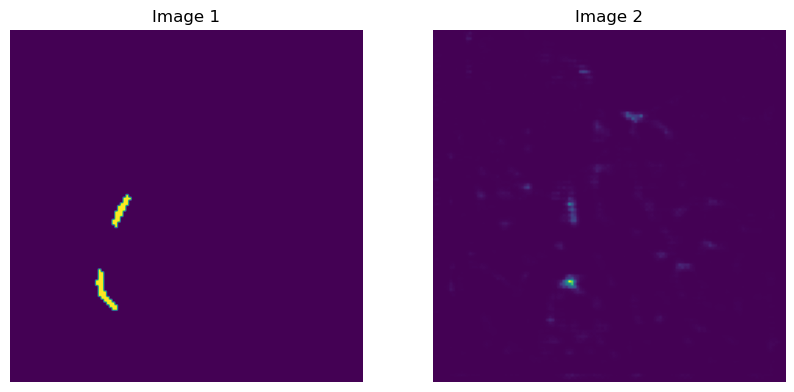

In [34]:
import matplotlib.pyplot as plt

def plot_images_side_by_side(image1, image2):
    # Load images
    # Create subplots
    plt.figure(figsize=(10, 5))

    # Plot image 1
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title('Image 1')
    plt.axis('off')

    # Plot image 2
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title('Image 2')
    plt.axis('off')

    plt.show()

i = 5
plot_images_side_by_side(test_input[1][i], out[i])

In [114]:
model.save_weights("../experiments/model.weights.h5")